In [1]:
from datetime import datetime
log_dict = {'TimeLog': {'시작': datetime.now().strftime('%Y-%m-%d %H:%M:%S')}}
print('TimeLog:', '시작', log_dict['TimeLog']['시작'])

TimeLog: 시작 2025-05-03 08:53:53


In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.0.1
True
NVIDIA GeForce RTX 3060


# 1. GPU 확인
- 현재 버전에서는 tesla T4 x 2 개의 GPU 로 학습하도록 설정하였습니다.
- tesla T4 x 1 로 학습 가능합니다. 

In [3]:
import os
import logging

log_dict['TimeLog']['1. GPU 확인'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('TimeLog:', log_dict['TimeLog']['1. GPU 확인'])
print()

os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TOKENIZERS_PARALLELISM"]="false"
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS']='true'

logging.disable(logging.INFO) 
logging.disable(logging.WARNING)

model_name = 'gogamza/kobart-base-v2'

!nvidia-smi

TimeLog: 2025-05-03 08:53:56

Sat May  3 08:53:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:04:00.0  On |                  N/A |
|  0%   54C    P8             19W /  170W |    2729MiB /  12288MiB |     29%      Default |
|                                         |                        |                  N/A |
+-----------------

# 2. 데이터 로드

- Json 학습데이터에서 요약 Task 에 필요한 데이터만 로드
- 원문 - 요약문 데이터 쌍 마다 저장하고, 데이터에 아이디를 부여

In [4]:
import os
import glob
import json
from bs4 import BeautifulSoup

def load_json_from_dir(dir_path):
    json_files = glob.glob(os.path.join(dir_path, '**/*.json'), recursive=True)
    json_data = []
    for file in json_files:
        try:
            with open(file, 'r', encoding='utf-8-sig') as f:
                temp_json = json.load(f)
                doc_id = str(temp_json['info']['id'])
                json_data.append(
                    {
                        'id': doc_id,
                        'summ_contxt': temp_json['Summary'][0]['summ_contxt'],
                        'summ_pass': temp_json['Summary'][0]['summ_pass'],
                    }
                )
        except Exception as e:
            print(file, e)
    return json_data

In [5]:
log_dict['TimeLog']['2. 데이터 로드'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('TimeLog:', log_dict['TimeLog']['2. 데이터 로드'])
print()

raw_train_json = load_json_from_dir('data/1.Training/')
raw_validation_json = load_json_from_dir('data/2.Validation/')
raw_test_json = load_json_from_dir('data/3.Test/')

print('train data size:', len(raw_train_json))
print('val   data size:', len(raw_validation_json))
print('test  data size:', len(raw_test_json))

TimeLog: 2025-05-03 08:53:58

train data size: 23022
val   data size: 3190
test  data size: 2554


## 2-1. 데이터 샘플

In [5]:
raw_train_json[0]

{'id': '42016558',
 'summ_contxt': '누구든지 정당의 후보자추천 관련 금품을 수수하지 못하도록 금지한 공직선거법 제47조의2 제1항에서 ‘후보자로 추천하는 일과 관련하여’란, 금품의 제공이 후보자 추천의 대가 또는 사례에 해당하거나 그렇지 않다 하더라도 후보자 추천에 관하여 그러한 금품의 제공이 어떠한 형태로든 영향을 미칠 수 있는 경우에 해당하는 것을 의미한다(대법원 2009. 4. 23. 선고 2009도834 판결). 또한 국회의원 선거에서 정당의 공천을 받게 하여 줄 의사나 능력이 없음에도 이를 해 줄 수 있는 것처럼 기망하여 공천과 관련하여 금품을 받은 경우 공직선거법상 공천 관련 금품 수수죄와 사기죄가 모두 성립하고 양자는 상상적 경합의 관계에 있다(대법원 2009. 4. 23. 선고 2009도834 판결 참조).\n원심판결 이유를 위 법리 및 적법하게 채택된 증거들에 비추어 살펴보면, 원심의 이러한 판단에 상고이유 주장과 같이 논리와 경험의 법칙을 위반하여 자유심증주의의 한계를 벗어나거나 위 공직선거법 규정 위반죄의 주체와 구성요건 및 사기죄와의 관계 등에 관한 법리를 오해하고 필요한 심리를 다하지 아니하여 판결에 영향을 미친 위법이 없다.',
 'summ_pass': '원심판결 이유를 위 법리 및 적법하게 채택된 증거들에 비추어 살펴보면, 원심의 이러한 판단에 상고이유 주장과 같이 논리와 경험의 법칙을 위반하여 자유심증주의의 한계를 벗어나거나 위 공직선거법 규정 위반죄의 주체와 구성요건 및 사기죄와의 관계 등에 관한 법리를 오해하고 필요한 심리를 다하지 아니하여 판결에 영향을 미친 위법이 없다.'}

# 3. 학습데이터 전처리

- 요약 Task를 위한 BART 모델을 불러오고,
- Tokenizer 를 통해 BART 모델의 max_seq 값을 넘는 데이터는 제외하도록 처리
- 요약 Task 에 불필요한 TAG, ()괄호안의 내용도 제거

In [6]:
import re
import tqdm
from transformers import PreTrainedTokenizerFast


def preprocessing(list_of_dict_data):
    data_trimmed = []
    for data in list_of_dict_data:
        data['summ_contxt'] = data['summ_contxt'].replace('_x000D_', '').replace('\r', '').replace('\n', ' ').strip()
        data['summ_pass'] = data['summ_pass'].replace('_x000D_', '').replace('\r', '').replace('\n', ' ').strip()
        data_trimmed.append(data)
    return data_trimmed

In [7]:
log_dict['TimeLog']['3. 학습데이터 전처리'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('TimeLog:', log_dict['TimeLog']['3. 학습데이터 전처리'])
print()

raw_train_data = preprocessing(raw_train_json)
raw_validation_data = preprocessing(raw_validation_json)
raw_test_data = preprocessing(raw_test_json)

print('train data size:', len(raw_train_data))
print('val   data size:', len(raw_validation_data))
print('test  data size:', len(raw_test_data))

TimeLog: 2024-02-21 10:34:20

train data size: 53209
val   data size: 6651
test  data size: 6651


## 3-1. 전처리후 데이터 샘플

In [8]:
raw_test_data[0]

{'id': '41018258',
 'summ_contxt': '함정수사라 함은 본래 범의를 가지지 아니한 자에 대하여 수사기관이 사술이나 계략 등을 써서 범의를 유발케 하여 범죄인을 검거하는 수사방법을 말하는 것이므로, 범의를 가진 자에 대하여 범행의 기회를 주거나 범행을 용이하게 한 것에 불과한 경우에는 함정수사라고 말할 수 없다(당원 1983. 4. 12. 선고 82도2433 판결 참조).',
 'summ_pass': '범의를 가진 자에 대하여 범행의 기회를 주거나 범행을 용이하게 한 것에 불과한 경우에는 함정수사라고 말할 수 없다.'}

# 4. 학습데이터 빌드

In [9]:
from sklearn.model_selection import train_test_split
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

log_dict['TimeLog']['4. 학습데이터 빌드'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('TimeLog:', log_dict['TimeLog']['4. 학습데이터 빌드'])
print()

raw_train_set = Dataset.from_list(raw_train_data)
raw_valid_set = Dataset.from_list(raw_validation_data)
raw_test_set = Dataset.from_list(raw_test_data)
raw_datasets = DatasetDict(
    {
        'train': raw_train_set,
        'val': raw_valid_set,
        'test': raw_test_set
    }
)

print('학습/테스트 데이터의 구성: ')
print(raw_datasets)

max_input_length = 1024
max_target_length = 1024

def data_build_function(examples):
    tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)

    inputs = [doc for doc in examples["summ_contxt"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    labels = tokenizer(text_target=[doc + '</s>' for doc in examples["summ_pass"]], max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(data_build_function, batched=True)

TimeLog: 2024-02-21 10:34:39

학습/테스트 데이터의 구성: 
DatasetDict({
    train: Dataset({
        features: ['id', 'summ_contxt', 'summ_pass'],
        num_rows: 53209
    })
    val: Dataset({
        features: ['id', 'summ_contxt', 'summ_pass'],
        num_rows: 6651
    })
    test: Dataset({
        features: ['id', 'summ_contxt', 'summ_pass'],
        num_rows: 6651
    })
})


Map:   0%|          | 0/53209 [00:00<?, ? examples/s]

Map:   0%|          | 0/6651 [00:00<?, ? examples/s]

Map:   0%|          | 0/6651 [00:00<?, ? examples/s]

# 5. 모델학습
- batch size: 4,  epoch: 15
- 매 epoch 마다 모델을 저장합니다. (save dir: /result/)
- 모델저장 디렉토리를 변경하려면, training_args 에 'output_dir' 을 수정하면 됩니다.

In [10]:
import nltk
import numpy as np
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, DataCollatorForSeq2Seq
from transformers import PreTrainedTokenizerFast
from transformers import BartForConditionalGeneration

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=False, use_aggregator=False)
    result = {key: value * 100 for key, value in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    return {k: round(v, 4) for k, v in result.items()}


tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

model_dir_path = datetime.now().strftime('%Y-%m-%d %H:%M')

training_args = Seq2SeqTrainingArguments(
    output_dir='result/%s/' % model_dir_path, 
    logging_dir='logs/%s/' % model_dir_path,
    evaluation_strategy="epoch", 
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=2,  
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    weight_decay=1e-2,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    max_grad_norm=1.0,
    warmup_ratio=0.0,
    num_train_epochs=10,
    logging_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    dataloader_num_workers=1,
    disable_tqdm=False,
    report_to="none",
    generation_max_length=1024,
    generation_num_beams=512,
    predict_with_generate=True,
)

trainer = Trainer(
    model=model, 
    args=training_args, 
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    train_dataset=tokenized_datasets['train'], 
    eval_dataset=tokenized_datasets['val'],
    # compute_metrics=compute_metrics
)

In [11]:
log_dict['TimeLog']['5. 모델학습 - 시작'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('TimeLog: 학습시작', log_dict['TimeLog']['5. 모델학습 - 시작'])
print()

train_result = trainer.train() 
log_dict['TimeLog']['5. 모델학습 - 종료'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print()
print('TimeLog: 학습종료', log_dict['TimeLog']['5. 모델학습 - 종료'])

TimeLog: 학습시작 2024-02-21 10:36:21



Epoch,Training Loss,Validation Loss
0,0.355000,0.243068
2,0.241500,0.229965
4,0.199000,0.232477
6,0.171100,0.241115
8,0.153800,0.245248
9,0.148400,0.247062



TimeLog: 학습종료 2024-02-21 15:08:35


In [12]:
from datetime import timedelta

log_dict['train_output'] = {
        'global_step': train_result.global_step, 
        'training_loss': train_result.training_loss, 
        'metrics': train_result.metrics
    }
log_dict['train_runtime'] = str(timedelta(seconds=train_result.metrics['train_runtime'])),
log_dict['log_history'] = trainer.state.log_history

## 5-1. Loss Plot
- 학습과정의 validation loss 그래프를 나타냄.
- validation loss 가 가장 낮은 모델의 checkpoint 를 이용해 모델 확정

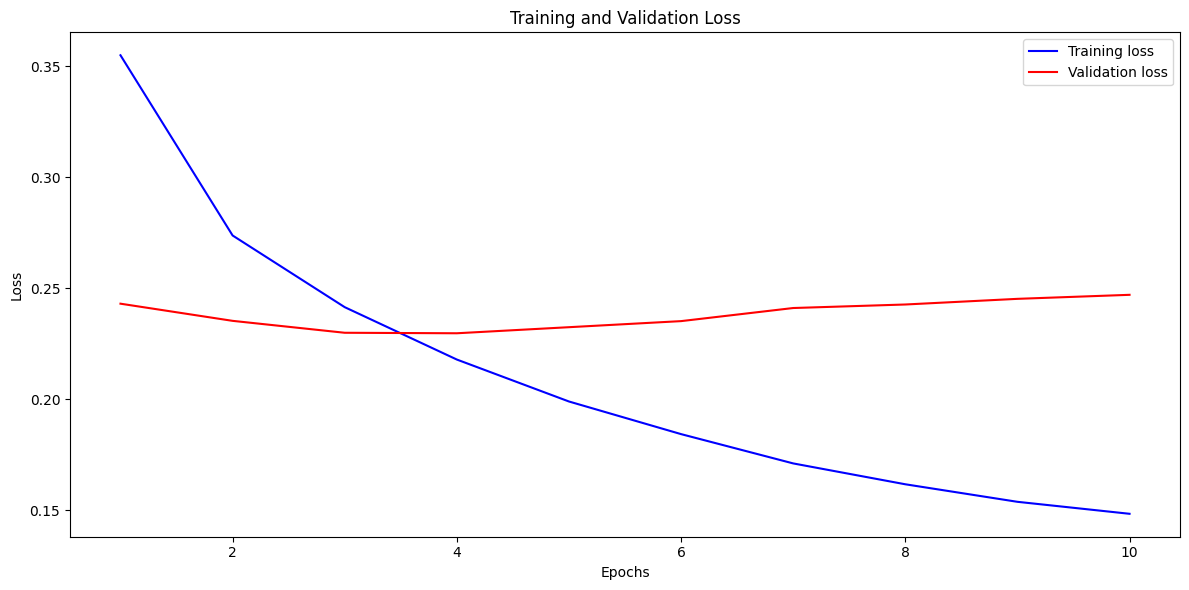

In [13]:
import matplotlib.pyplot as plt

train_loss = []
validation_loss = []
for log in trainer.state.log_history:
    if 'loss' in log.keys():
        train_loss.append(log['loss'])
    elif 'eval_loss' in log.keys():
        validation_loss.append(log['eval_loss'])

epochs = range(1, 10 + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [14]:
log_dict['TimeLog']['종료'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('TimeLog: 종료', log_dict['TimeLog']['종료'])
with open('%s-모델학습로그.json' % model_dir_path, 'w') as outfile:
    json.dump(log_dict, outfile, ensure_ascii=False, indent=4)

TimeLog: 종료 2024-02-21 15:08:36
